In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [5]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [6]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [7]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [8]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 1
            # if row['Open'] - row['Low'] > stop_loss:
            #     return 0
            # else:
            #     return 1
        else:
            return (-1)
            # if row['High'] - row['Open'] > stop_loss:
            #     return 0
            # else:
            #     return (-1)
    else:
        return 0
    # df['target'] = df.apply(calculate_target, axis=1)
    # df.target = df.target.shift(-1)
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [9]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

            gains     Open     High      Low   Settle  target
Date                                                         
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0       1
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0       1
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0       0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0       0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,1.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,0.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,-1.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [10]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,1.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,-1.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


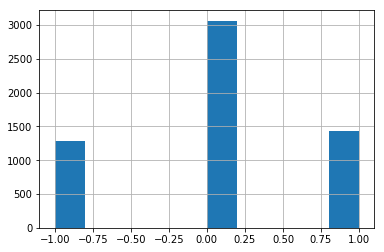

In [11]:
gold['target'].hist()

In [12]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

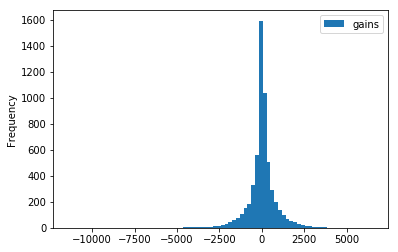

In [13]:
gold_gains[['gains']].plot.hist(bins=80)

In [14]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 100
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5       1
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0       0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0      -1
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0       0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0      -1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0


In [15]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

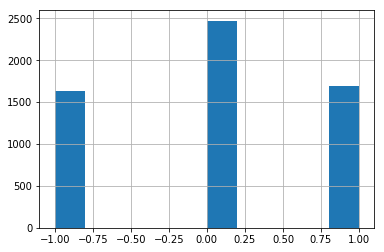

In [16]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

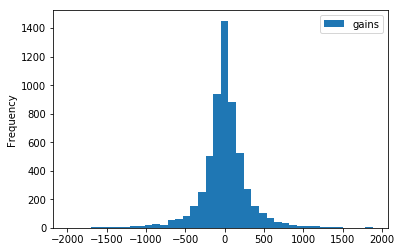

In [17]:
corn_gains[['gains']].plot.hist(bins=40)

In [18]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,-1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,-1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,1.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,1.0


In [19]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains.head(5)

                gains     Open      High      Low    Settle  target
Date                                                               
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75      -1
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25       1
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75       1
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75      -1
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50       1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25,1.0
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75,1.0
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75,-1.0
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50,1.0
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75,1.0


In [20]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

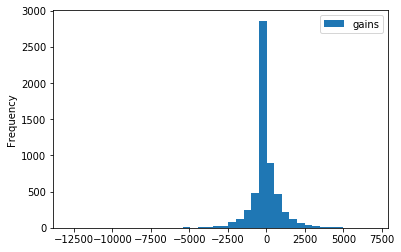

In [21]:
coffee_gains[['gains']].plot.hist(bins=40)

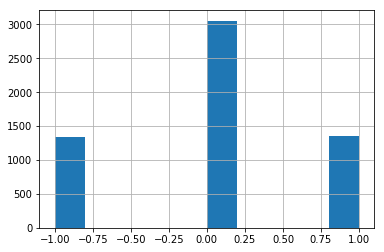

In [22]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [23]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,-1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,17.127072,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-17,103.05,105.50,103.05,104.30,6504.0,16852.0,7.947020,1.0


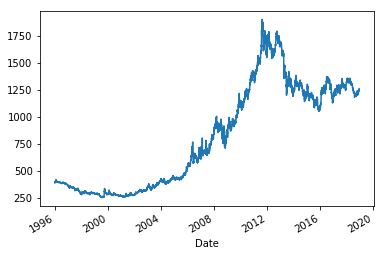

In [24]:
gold['Open'].plot()

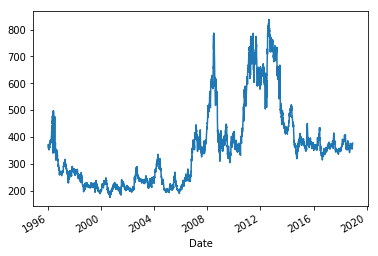

In [25]:
corn['Open'].plot()

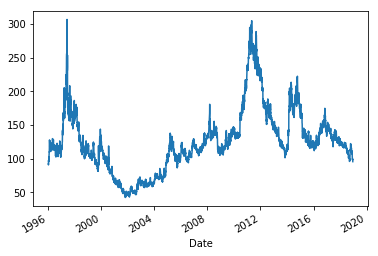

In [26]:
coffee['Open'].plot()

In [27]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [28]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [29]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [30]:
gold_data.shape

(5276, 3046)

In [31]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [32]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [94]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    return df_pca

In [95]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [96]:
# plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [97]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [98]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [99]:
pca_components = 3

In [100]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [101]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [102]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=list(map(lambda x: x+1, gold_label_train)), categorical_feature='auto') # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x+1, gold_label_test)), categorical_feature='auto')
param = {'num_leaves':31, 'objective':'multiclass'}
# param['metric'] = 'auc'
# param['boosting_type'] = 'gbdt'
# param['metric'] = 'rmse'
param['boosting'] = 'dart'
# param['max_bin'] = 50
# param['metric'] = 'multi_error'
param['metric'] = 'multi_logloss'
param['learning_rate'] = 0.05
param['num_class'] = 3
param['max_bin'] = 50
num_round = 2000
# param = {'boosting_type': 'gbdt',
#          'max_depth' : -1,
#           'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1,
#           'num_class' : 1,
#           'metric' : 'binary_error'}
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

[1]	valid_0's multi_logloss: 1.097
[2]	valid_0's multi_logloss: 1.09515
[3]	valid_0's multi_logloss: 1.0937
[4]	valid_0's multi_logloss: 1.09233
[5]	valid_0's multi_logloss: 1.09111
[6]	valid_0's multi_logloss: 1.08958
[7]	valid_0's multi_logloss: 1.08838
[8]	valid_0's multi_logloss: 1.08876
[9]	valid_0's multi_logloss: 1.08845
[10]	valid_0's multi_logloss: 1.08698
[11]	valid_0's multi_logloss: 1.08657
[12]	valid_0's multi_logloss: 1.08686
[13]	valid_0's multi_logloss: 1.08616
[14]	valid_0's multi_logloss: 1.08581
[15]	valid_0's multi_logloss: 1.0851
[16]	valid_0's multi_logloss: 1.08464
[17]	valid_0's multi_logloss: 1.08366
[18]	valid_0's multi_logloss: 1.0836
[19]	valid_0's multi_logloss: 1.08337
[20]	valid_0's multi_logloss: 1.08352
[21]	valid_0's multi_logloss: 1.08345
[22]	valid_0's multi_logloss: 1.08351
[23]	valid_0's multi_logloss: 1.08381
[24]	valid_0's multi_logloss: 1.08402
[25]	valid_0's multi_logloss: 1.08479
[26]	valid_0's multi_logloss: 1.08504
[27]	valid_0's multi_loglo

[244]	valid_0's multi_logloss: 1.11686
[245]	valid_0's multi_logloss: 1.11738
[246]	valid_0's multi_logloss: 1.11786
[247]	valid_0's multi_logloss: 1.11868
[248]	valid_0's multi_logloss: 1.11814
[249]	valid_0's multi_logloss: 1.11766
[250]	valid_0's multi_logloss: 1.11833
[251]	valid_0's multi_logloss: 1.11778
[252]	valid_0's multi_logloss: 1.1173
[253]	valid_0's multi_logloss: 1.11788
[254]	valid_0's multi_logloss: 1.11832
[255]	valid_0's multi_logloss: 1.11914
[256]	valid_0's multi_logloss: 1.11976
[257]	valid_0's multi_logloss: 1.1208
[258]	valid_0's multi_logloss: 1.1212
[259]	valid_0's multi_logloss: 1.12062
[260]	valid_0's multi_logloss: 1.12006
[261]	valid_0's multi_logloss: 1.11946
[262]	valid_0's multi_logloss: 1.12005
[263]	valid_0's multi_logloss: 1.12126
[264]	valid_0's multi_logloss: 1.12125
[265]	valid_0's multi_logloss: 1.12189
[266]	valid_0's multi_logloss: 1.12308
[267]	valid_0's multi_logloss: 1.12256
[268]	valid_0's multi_logloss: 1.12333
[269]	valid_0's multi_loglos

[457]	valid_0's multi_logloss: 1.15028
[458]	valid_0's multi_logloss: 1.1506
[459]	valid_0's multi_logloss: 1.15125
[460]	valid_0's multi_logloss: 1.1507
[461]	valid_0's multi_logloss: 1.15086
[462]	valid_0's multi_logloss: 1.15031
[463]	valid_0's multi_logloss: 1.14975
[464]	valid_0's multi_logloss: 1.15027
[465]	valid_0's multi_logloss: 1.15122
[466]	valid_0's multi_logloss: 1.15068
[467]	valid_0's multi_logloss: 1.15111
[468]	valid_0's multi_logloss: 1.15056
[469]	valid_0's multi_logloss: 1.15136
[470]	valid_0's multi_logloss: 1.15086
[471]	valid_0's multi_logloss: 1.15136
[472]	valid_0's multi_logloss: 1.1508
[473]	valid_0's multi_logloss: 1.15092
[474]	valid_0's multi_logloss: 1.15145
[475]	valid_0's multi_logloss: 1.15158
[476]	valid_0's multi_logloss: 1.151
[477]	valid_0's multi_logloss: 1.15203
[478]	valid_0's multi_logloss: 1.1515
[479]	valid_0's multi_logloss: 1.15092
[480]	valid_0's multi_logloss: 1.15154
[481]	valid_0's multi_logloss: 1.15192
[482]	valid_0's multi_logloss: 

[685]	valid_0's multi_logloss: 1.17987
[686]	valid_0's multi_logloss: 1.18043
[687]	valid_0's multi_logloss: 1.1799
[688]	valid_0's multi_logloss: 1.17943
[689]	valid_0's multi_logloss: 1.17962
[690]	valid_0's multi_logloss: 1.18019
[691]	valid_0's multi_logloss: 1.17973
[692]	valid_0's multi_logloss: 1.17926
[693]	valid_0's multi_logloss: 1.1801
[694]	valid_0's multi_logloss: 1.18063
[695]	valid_0's multi_logloss: 1.18015
[696]	valid_0's multi_logloss: 1.18064
[697]	valid_0's multi_logloss: 1.18122
[698]	valid_0's multi_logloss: 1.18192
[699]	valid_0's multi_logloss: 1.18139
[700]	valid_0's multi_logloss: 1.18214
[701]	valid_0's multi_logloss: 1.18266
[702]	valid_0's multi_logloss: 1.18345
[703]	valid_0's multi_logloss: 1.18307
[704]	valid_0's multi_logloss: 1.18258
[705]	valid_0's multi_logloss: 1.1821
[706]	valid_0's multi_logloss: 1.18167
[707]	valid_0's multi_logloss: 1.18124
[708]	valid_0's multi_logloss: 1.1818
[709]	valid_0's multi_logloss: 1.18225
[710]	valid_0's multi_logloss

[913]	valid_0's multi_logloss: 1.20671
[914]	valid_0's multi_logloss: 1.20678
[915]	valid_0's multi_logloss: 1.20678
[916]	valid_0's multi_logloss: 1.20633
[917]	valid_0's multi_logloss: 1.20595
[918]	valid_0's multi_logloss: 1.20552
[919]	valid_0's multi_logloss: 1.20506
[920]	valid_0's multi_logloss: 1.20462
[921]	valid_0's multi_logloss: 1.20424
[922]	valid_0's multi_logloss: 1.2038
[923]	valid_0's multi_logloss: 1.20347
[924]	valid_0's multi_logloss: 1.20399
[925]	valid_0's multi_logloss: 1.20465
[926]	valid_0's multi_logloss: 1.20533
[927]	valid_0's multi_logloss: 1.20494
[928]	valid_0's multi_logloss: 1.20459
[929]	valid_0's multi_logloss: 1.20509
[930]	valid_0's multi_logloss: 1.2057
[931]	valid_0's multi_logloss: 1.20534
[932]	valid_0's multi_logloss: 1.20498
[933]	valid_0's multi_logloss: 1.2052
[934]	valid_0's multi_logloss: 1.20578
[935]	valid_0's multi_logloss: 1.20672
[936]	valid_0's multi_logloss: 1.2063
[937]	valid_0's multi_logloss: 1.20579
[938]	valid_0's multi_logloss

[1130]	valid_0's multi_logloss: 1.22037
[1131]	valid_0's multi_logloss: 1.22
[1132]	valid_0's multi_logloss: 1.22023
[1133]	valid_0's multi_logloss: 1.22033
[1134]	valid_0's multi_logloss: 1.22114
[1135]	valid_0's multi_logloss: 1.22126
[1136]	valid_0's multi_logloss: 1.22093
[1137]	valid_0's multi_logloss: 1.22053
[1138]	valid_0's multi_logloss: 1.22019
[1139]	valid_0's multi_logloss: 1.21988
[1140]	valid_0's multi_logloss: 1.22047
[1141]	valid_0's multi_logloss: 1.22007
[1142]	valid_0's multi_logloss: 1.21968
[1143]	valid_0's multi_logloss: 1.22033
[1144]	valid_0's multi_logloss: 1.22132
[1145]	valid_0's multi_logloss: 1.22187
[1146]	valid_0's multi_logloss: 1.22153
[1147]	valid_0's multi_logloss: 1.22208
[1148]	valid_0's multi_logloss: 1.22167
[1149]	valid_0's multi_logloss: 1.22252
[1150]	valid_0's multi_logloss: 1.22215
[1151]	valid_0's multi_logloss: 1.22174
[1152]	valid_0's multi_logloss: 1.22134
[1153]	valid_0's multi_logloss: 1.22093
[1154]	valid_0's multi_logloss: 1.22129
[11

[1340]	valid_0's multi_logloss: 1.24404
[1341]	valid_0's multi_logloss: 1.24367
[1342]	valid_0's multi_logloss: 1.24462
[1343]	valid_0's multi_logloss: 1.24433
[1344]	valid_0's multi_logloss: 1.24393
[1345]	valid_0's multi_logloss: 1.24362
[1346]	valid_0's multi_logloss: 1.24319
[1347]	valid_0's multi_logloss: 1.24393
[1348]	valid_0's multi_logloss: 1.24356
[1349]	valid_0's multi_logloss: 1.24415
[1350]	valid_0's multi_logloss: 1.24378
[1351]	valid_0's multi_logloss: 1.24439
[1352]	valid_0's multi_logloss: 1.24399
[1353]	valid_0's multi_logloss: 1.24488
[1354]	valid_0's multi_logloss: 1.2458
[1355]	valid_0's multi_logloss: 1.24679
[1356]	valid_0's multi_logloss: 1.24715
[1357]	valid_0's multi_logloss: 1.24768
[1358]	valid_0's multi_logloss: 1.24729
[1359]	valid_0's multi_logloss: 1.24798
[1360]	valid_0's multi_logloss: 1.24761
[1361]	valid_0's multi_logloss: 1.24853
[1362]	valid_0's multi_logloss: 1.24924
[1363]	valid_0's multi_logloss: 1.25019
[1364]	valid_0's multi_logloss: 1.25091
[

[1557]	valid_0's multi_logloss: 1.27004
[1558]	valid_0's multi_logloss: 1.26974
[1559]	valid_0's multi_logloss: 1.27016
[1560]	valid_0's multi_logloss: 1.26987
[1561]	valid_0's multi_logloss: 1.27016
[1562]	valid_0's multi_logloss: 1.26979
[1563]	valid_0's multi_logloss: 1.26949
[1564]	valid_0's multi_logloss: 1.27011
[1565]	valid_0's multi_logloss: 1.26975
[1566]	valid_0's multi_logloss: 1.27049
[1567]	valid_0's multi_logloss: 1.27018
[1568]	valid_0's multi_logloss: 1.27066
[1569]	valid_0's multi_logloss: 1.2713
[1570]	valid_0's multi_logloss: 1.27201
[1571]	valid_0's multi_logloss: 1.27241
[1572]	valid_0's multi_logloss: 1.27304
[1573]	valid_0's multi_logloss: 1.27373
[1574]	valid_0's multi_logloss: 1.27431
[1575]	valid_0's multi_logloss: 1.2749
[1576]	valid_0's multi_logloss: 1.27564
[1577]	valid_0's multi_logloss: 1.27608
[1578]	valid_0's multi_logloss: 1.27659
[1579]	valid_0's multi_logloss: 1.27634
[1580]	valid_0's multi_logloss: 1.27601
[1581]	valid_0's multi_logloss: 1.27656
[1

[1775]	valid_0's multi_logloss: 1.31317
[1776]	valid_0's multi_logloss: 1.31417
[1777]	valid_0's multi_logloss: 1.31389
[1778]	valid_0's multi_logloss: 1.31491
[1779]	valid_0's multi_logloss: 1.31462
[1780]	valid_0's multi_logloss: 1.31496
[1781]	valid_0's multi_logloss: 1.31554
[1782]	valid_0's multi_logloss: 1.31529
[1783]	valid_0's multi_logloss: 1.31583
[1784]	valid_0's multi_logloss: 1.31601
[1785]	valid_0's multi_logloss: 1.31568
[1786]	valid_0's multi_logloss: 1.31541
[1787]	valid_0's multi_logloss: 1.31581
[1788]	valid_0's multi_logloss: 1.3165
[1789]	valid_0's multi_logloss: 1.31613
[1790]	valid_0's multi_logloss: 1.3169
[1791]	valid_0's multi_logloss: 1.3165
[1792]	valid_0's multi_logloss: 1.31726
[1793]	valid_0's multi_logloss: 1.31691
[1794]	valid_0's multi_logloss: 1.31652
[1795]	valid_0's multi_logloss: 1.31678
[1796]	valid_0's multi_logloss: 1.31655
[1797]	valid_0's multi_logloss: 1.3162
[1798]	valid_0's multi_logloss: 1.31592
[1799]	valid_0's multi_logloss: 1.31567
[180

[1981]	valid_0's multi_logloss: 1.34281
[1982]	valid_0's multi_logloss: 1.34248
[1983]	valid_0's multi_logloss: 1.34284
[1984]	valid_0's multi_logloss: 1.34356
[1985]	valid_0's multi_logloss: 1.34319
[1986]	valid_0's multi_logloss: 1.3429
[1987]	valid_0's multi_logloss: 1.34264
[1988]	valid_0's multi_logloss: 1.34243
[1989]	valid_0's multi_logloss: 1.34305
[1990]	valid_0's multi_logloss: 1.34272
[1991]	valid_0's multi_logloss: 1.34295
[1992]	valid_0's multi_logloss: 1.34366
[1993]	valid_0's multi_logloss: 1.34337
[1994]	valid_0's multi_logloss: 1.34403
[1995]	valid_0's multi_logloss: 1.34446
[1996]	valid_0's multi_logloss: 1.34415
[1997]	valid_0's multi_logloss: 1.34389
[1998]	valid_0's multi_logloss: 1.34467
[1999]	valid_0's multi_logloss: 1.34539
[2000]	valid_0's multi_logloss: 1.34559


In [149]:
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: x+1, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: x+1, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
corn_xgb_use = True
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's multi_logloss: 1.09574
[2]	valid_0's multi_logloss: 1.09287
[3]	valid_0's multi_logloss: 1.0909
[4]	valid_0's multi_logloss: 1.08887
[5]	valid_0's multi_logloss: 1.08721
[6]	valid_0's multi_logloss: 1.086
[7]	valid_0's multi_logloss: 1.08502
[8]	valid_0's multi_logloss: 1.08547
[9]	valid_0's multi_logloss: 1.0843
[10]	valid_0's multi_logloss: 1.0828
[11]	valid_0's multi_logloss: 1.08197
[12]	valid_0's multi_logloss: 1.08237
[13]	valid_0's multi_logloss: 1.08161
[14]	valid_0's multi_logloss: 1.08072
[15]	valid_0's multi_logloss: 1.08058
[16]	valid_0's multi_logloss: 1.08036
[17]	valid_0's multi_logloss: 1.08065
[18]	valid_0's multi_logloss: 1.08034
[19]	valid_0's multi_logloss: 1.08087
[20]	valid_0's multi_logloss: 1.08071
[21]	valid_0's multi_logloss: 1.08051
[22]	valid_0's multi_logloss: 1.08099
[23]	valid_0's multi_logloss: 1.08065
[24]	valid_0's multi_logloss: 1.08056
[25]	valid_0's multi_logloss: 1.08066
[26]	valid_0's multi_logloss: 1.0813
[27]	valid_0's multi_loglos

[252]	valid_0's multi_logloss: 1.09491
[253]	valid_0's multi_logloss: 1.09558
[254]	valid_0's multi_logloss: 1.09614
[255]	valid_0's multi_logloss: 1.09667
[256]	valid_0's multi_logloss: 1.09707
[257]	valid_0's multi_logloss: 1.09748
[258]	valid_0's multi_logloss: 1.09814
[259]	valid_0's multi_logloss: 1.09778
[260]	valid_0's multi_logloss: 1.09733
[261]	valid_0's multi_logloss: 1.09692
[262]	valid_0's multi_logloss: 1.09704
[263]	valid_0's multi_logloss: 1.0977
[264]	valid_0's multi_logloss: 1.09821
[265]	valid_0's multi_logloss: 1.09838
[266]	valid_0's multi_logloss: 1.09847
[267]	valid_0's multi_logloss: 1.09806
[268]	valid_0's multi_logloss: 1.0983
[269]	valid_0's multi_logloss: 1.09783
[270]	valid_0's multi_logloss: 1.09792
[271]	valid_0's multi_logloss: 1.09753
[272]	valid_0's multi_logloss: 1.09758
[273]	valid_0's multi_logloss: 1.09805
[274]	valid_0's multi_logloss: 1.09768
[275]	valid_0's multi_logloss: 1.09829
[276]	valid_0's multi_logloss: 1.09791
[277]	valid_0's multi_loglo

[490]	valid_0's multi_logloss: 1.13262
[491]	valid_0's multi_logloss: 1.13222
[492]	valid_0's multi_logloss: 1.13179
[493]	valid_0's multi_logloss: 1.13131
[494]	valid_0's multi_logloss: 1.13154
[495]	valid_0's multi_logloss: 1.13219
[496]	valid_0's multi_logloss: 1.13291
[497]	valid_0's multi_logloss: 1.13331
[498]	valid_0's multi_logloss: 1.13374
[499]	valid_0's multi_logloss: 1.13328
[500]	valid_0's multi_logloss: 1.13391
[501]	valid_0's multi_logloss: 1.13348
[502]	valid_0's multi_logloss: 1.13377
[503]	valid_0's multi_logloss: 1.13424
[504]	valid_0's multi_logloss: 1.13373
[505]	valid_0's multi_logloss: 1.13335
[506]	valid_0's multi_logloss: 1.13366
[507]	valid_0's multi_logloss: 1.13417
[508]	valid_0's multi_logloss: 1.13456
[509]	valid_0's multi_logloss: 1.13479
[510]	valid_0's multi_logloss: 1.1351
[511]	valid_0's multi_logloss: 1.1346
[512]	valid_0's multi_logloss: 1.13479
[513]	valid_0's multi_logloss: 1.13463
[514]	valid_0's multi_logloss: 1.13543
[515]	valid_0's multi_loglo

[718]	valid_0's multi_logloss: 1.1499
[719]	valid_0's multi_logloss: 1.14944
[720]	valid_0's multi_logloss: 1.14901
[721]	valid_0's multi_logloss: 1.14914
[722]	valid_0's multi_logloss: 1.14876
[723]	valid_0's multi_logloss: 1.149
[724]	valid_0's multi_logloss: 1.14931
[725]	valid_0's multi_logloss: 1.14888
[726]	valid_0's multi_logloss: 1.14939
[727]	valid_0's multi_logloss: 1.14984
[728]	valid_0's multi_logloss: 1.15047
[729]	valid_0's multi_logloss: 1.15008
[730]	valid_0's multi_logloss: 1.15046
[731]	valid_0's multi_logloss: 1.15002
[732]	valid_0's multi_logloss: 1.14968
[733]	valid_0's multi_logloss: 1.15004
[734]	valid_0's multi_logloss: 1.1496
[735]	valid_0's multi_logloss: 1.14991
[736]	valid_0's multi_logloss: 1.14955
[737]	valid_0's multi_logloss: 1.14915
[738]	valid_0's multi_logloss: 1.14995
[739]	valid_0's multi_logloss: 1.15019
[740]	valid_0's multi_logloss: 1.15058
[741]	valid_0's multi_logloss: 1.15024
[742]	valid_0's multi_logloss: 1.15104
[743]	valid_0's multi_logloss

[957]	valid_0's multi_logloss: 1.17957
[958]	valid_0's multi_logloss: 1.17925
[959]	valid_0's multi_logloss: 1.17998
[960]	valid_0's multi_logloss: 1.18039
[961]	valid_0's multi_logloss: 1.18129
[962]	valid_0's multi_logloss: 1.18246
[963]	valid_0's multi_logloss: 1.18269
[964]	valid_0's multi_logloss: 1.18236
[965]	valid_0's multi_logloss: 1.18273
[966]	valid_0's multi_logloss: 1.18237
[967]	valid_0's multi_logloss: 1.18202
[968]	valid_0's multi_logloss: 1.18169
[969]	valid_0's multi_logloss: 1.18136
[970]	valid_0's multi_logloss: 1.18228
[971]	valid_0's multi_logloss: 1.18254
[972]	valid_0's multi_logloss: 1.18357
[973]	valid_0's multi_logloss: 1.18316
[974]	valid_0's multi_logloss: 1.18281
[975]	valid_0's multi_logloss: 1.18244
[976]	valid_0's multi_logloss: 1.18325
[977]	valid_0's multi_logloss: 1.18292
[978]	valid_0's multi_logloss: 1.18389
[979]	valid_0's multi_logloss: 1.18357
[980]	valid_0's multi_logloss: 1.18412
[981]	valid_0's multi_logloss: 1.18375
[982]	valid_0's multi_log

[1181]	valid_0's multi_logloss: 1.20449
[1182]	valid_0's multi_logloss: 1.20497
[1183]	valid_0's multi_logloss: 1.20547
[1184]	valid_0's multi_logloss: 1.20597
[1185]	valid_0's multi_logloss: 1.20667
[1186]	valid_0's multi_logloss: 1.2063
[1187]	valid_0's multi_logloss: 1.20674
[1188]	valid_0's multi_logloss: 1.20707
[1189]	valid_0's multi_logloss: 1.20678
[1190]	valid_0's multi_logloss: 1.2064
[1191]	valid_0's multi_logloss: 1.20608
[1192]	valid_0's multi_logloss: 1.20573
[1193]	valid_0's multi_logloss: 1.2054
[1194]	valid_0's multi_logloss: 1.20592
[1195]	valid_0's multi_logloss: 1.20658
[1196]	valid_0's multi_logloss: 1.20671
[1197]	valid_0's multi_logloss: 1.20756
[1198]	valid_0's multi_logloss: 1.20811
[1199]	valid_0's multi_logloss: 1.20772
[1200]	valid_0's multi_logloss: 1.20735
[1201]	valid_0's multi_logloss: 1.20777
[1202]	valid_0's multi_logloss: 1.2086
[1203]	valid_0's multi_logloss: 1.20901
[1204]	valid_0's multi_logloss: 1.20875
[1205]	valid_0's multi_logloss: 1.20846
[120

[1408]	valid_0's multi_logloss: 1.2367
[1409]	valid_0's multi_logloss: 1.23738
[1410]	valid_0's multi_logloss: 1.23692
[1411]	valid_0's multi_logloss: 1.23662
[1412]	valid_0's multi_logloss: 1.23698
[1413]	valid_0's multi_logloss: 1.23748
[1414]	valid_0's multi_logloss: 1.23717
[1415]	valid_0's multi_logloss: 1.23687
[1416]	valid_0's multi_logloss: 1.23756
[1417]	valid_0's multi_logloss: 1.2373
[1418]	valid_0's multi_logloss: 1.237
[1419]	valid_0's multi_logloss: 1.23803
[1420]	valid_0's multi_logloss: 1.2377
[1421]	valid_0's multi_logloss: 1.23813
[1422]	valid_0's multi_logloss: 1.23788
[1423]	valid_0's multi_logloss: 1.23873
[1424]	valid_0's multi_logloss: 1.23838
[1425]	valid_0's multi_logloss: 1.23809
[1426]	valid_0's multi_logloss: 1.23844
[1427]	valid_0's multi_logloss: 1.23935
[1428]	valid_0's multi_logloss: 1.23908
[1429]	valid_0's multi_logloss: 1.2398
[1430]	valid_0's multi_logloss: 1.23947
[1431]	valid_0's multi_logloss: 1.23911
[1432]	valid_0's multi_logloss: 1.23883
[1433]

[1616]	valid_0's multi_logloss: 1.26004
[1617]	valid_0's multi_logloss: 1.25982
[1618]	valid_0's multi_logloss: 1.25949
[1619]	valid_0's multi_logloss: 1.25925
[1620]	valid_0's multi_logloss: 1.25948
[1621]	valid_0's multi_logloss: 1.2602
[1622]	valid_0's multi_logloss: 1.26084
[1623]	valid_0's multi_logloss: 1.26154
[1624]	valid_0's multi_logloss: 1.26189
[1625]	valid_0's multi_logloss: 1.26264
[1626]	valid_0's multi_logloss: 1.2632
[1627]	valid_0's multi_logloss: 1.26289
[1628]	valid_0's multi_logloss: 1.26267
[1629]	valid_0's multi_logloss: 1.26242
[1630]	valid_0's multi_logloss: 1.26319
[1631]	valid_0's multi_logloss: 1.26382
[1632]	valid_0's multi_logloss: 1.26353
[1633]	valid_0's multi_logloss: 1.26327
[1634]	valid_0's multi_logloss: 1.26297
[1635]	valid_0's multi_logloss: 1.26265
[1636]	valid_0's multi_logloss: 1.26335
[1637]	valid_0's multi_logloss: 1.26392
[1638]	valid_0's multi_logloss: 1.26492
[1639]	valid_0's multi_logloss: 1.26563
[1640]	valid_0's multi_logloss: 1.26531
[1

[1824]	valid_0's multi_logloss: 1.28978
[1825]	valid_0's multi_logloss: 1.28954
[1826]	valid_0's multi_logloss: 1.28972
[1827]	valid_0's multi_logloss: 1.28931
[1828]	valid_0's multi_logloss: 1.29018
[1829]	valid_0's multi_logloss: 1.28992
[1830]	valid_0's multi_logloss: 1.28964
[1831]	valid_0's multi_logloss: 1.29006
[1832]	valid_0's multi_logloss: 1.29055
[1833]	valid_0's multi_logloss: 1.29025
[1834]	valid_0's multi_logloss: 1.29093
[1835]	valid_0's multi_logloss: 1.29055
[1836]	valid_0's multi_logloss: 1.29067
[1837]	valid_0's multi_logloss: 1.29031
[1838]	valid_0's multi_logloss: 1.29006
[1839]	valid_0's multi_logloss: 1.29103
[1840]	valid_0's multi_logloss: 1.29072
[1841]	valid_0's multi_logloss: 1.29144
[1842]	valid_0's multi_logloss: 1.29116
[1843]	valid_0's multi_logloss: 1.2908
[1844]	valid_0's multi_logloss: 1.29047
[1845]	valid_0's multi_logloss: 1.29017
[1846]	valid_0's multi_logloss: 1.29095
[1847]	valid_0's multi_logloss: 1.29063
[1848]	valid_0's multi_logloss: 1.29137
[

In [150]:
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: x+1, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x+1, coffee_label_test)), categorical_feature='auto')
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's multi_logloss: 1.09784
[2]	valid_0's multi_logloss: 1.09695
[3]	valid_0's multi_logloss: 1.09662
[4]	valid_0's multi_logloss: 1.09679
[5]	valid_0's multi_logloss: 1.09735
[6]	valid_0's multi_logloss: 1.09772
[7]	valid_0's multi_logloss: 1.09833
[8]	valid_0's multi_logloss: 1.09826
[9]	valid_0's multi_logloss: 1.09845
[10]	valid_0's multi_logloss: 1.0986
[11]	valid_0's multi_logloss: 1.09833
[12]	valid_0's multi_logloss: 1.09833
[13]	valid_0's multi_logloss: 1.0986
[14]	valid_0's multi_logloss: 1.09893
[15]	valid_0's multi_logloss: 1.09928
[16]	valid_0's multi_logloss: 1.0986
[17]	valid_0's multi_logloss: 1.09824
[18]	valid_0's multi_logloss: 1.0984
[19]	valid_0's multi_logloss: 1.09861
[20]	valid_0's multi_logloss: 1.09878
[21]	valid_0's multi_logloss: 1.09864
[22]	valid_0's multi_logloss: 1.09922
[23]	valid_0's multi_logloss: 1.09947
[24]	valid_0's multi_logloss: 1.10014
[25]	valid_0's multi_logloss: 1.10018
[26]	valid_0's multi_logloss: 1.10075
[27]	valid_0's multi_logl

[252]	valid_0's multi_logloss: 1.12926
[253]	valid_0's multi_logloss: 1.12958
[254]	valid_0's multi_logloss: 1.12983
[255]	valid_0's multi_logloss: 1.13001
[256]	valid_0's multi_logloss: 1.1314
[257]	valid_0's multi_logloss: 1.1316
[258]	valid_0's multi_logloss: 1.13262
[259]	valid_0's multi_logloss: 1.13215
[260]	valid_0's multi_logloss: 1.13161
[261]	valid_0's multi_logloss: 1.13113
[262]	valid_0's multi_logloss: 1.13224
[263]	valid_0's multi_logloss: 1.13241
[264]	valid_0's multi_logloss: 1.13327
[265]	valid_0's multi_logloss: 1.1338
[266]	valid_0's multi_logloss: 1.13409
[267]	valid_0's multi_logloss: 1.13357
[268]	valid_0's multi_logloss: 1.13414
[269]	valid_0's multi_logloss: 1.13362
[270]	valid_0's multi_logloss: 1.13434
[271]	valid_0's multi_logloss: 1.13385
[272]	valid_0's multi_logloss: 1.13472
[273]	valid_0's multi_logloss: 1.13571
[274]	valid_0's multi_logloss: 1.13524
[275]	valid_0's multi_logloss: 1.13566
[276]	valid_0's multi_logloss: 1.13513
[277]	valid_0's multi_loglos

[490]	valid_0's multi_logloss: 1.16846
[491]	valid_0's multi_logloss: 1.16794
[492]	valid_0's multi_logloss: 1.16749
[493]	valid_0's multi_logloss: 1.16701
[494]	valid_0's multi_logloss: 1.16797
[495]	valid_0's multi_logloss: 1.16877
[496]	valid_0's multi_logloss: 1.16921
[497]	valid_0's multi_logloss: 1.16972
[498]	valid_0's multi_logloss: 1.17071
[499]	valid_0's multi_logloss: 1.1702
[500]	valid_0's multi_logloss: 1.17114
[501]	valid_0's multi_logloss: 1.17062
[502]	valid_0's multi_logloss: 1.17108
[503]	valid_0's multi_logloss: 1.17156
[504]	valid_0's multi_logloss: 1.17104
[505]	valid_0's multi_logloss: 1.17056
[506]	valid_0's multi_logloss: 1.17113
[507]	valid_0's multi_logloss: 1.17166
[508]	valid_0's multi_logloss: 1.17238
[509]	valid_0's multi_logloss: 1.17331
[510]	valid_0's multi_logloss: 1.17375
[511]	valid_0's multi_logloss: 1.17326
[512]	valid_0's multi_logloss: 1.17395
[513]	valid_0's multi_logloss: 1.17497
[514]	valid_0's multi_logloss: 1.17546
[515]	valid_0's multi_logl

[719]	valid_0's multi_logloss: 1.18788
[720]	valid_0's multi_logloss: 1.18745
[721]	valid_0's multi_logloss: 1.18781
[722]	valid_0's multi_logloss: 1.18742
[723]	valid_0's multi_logloss: 1.18846
[724]	valid_0's multi_logloss: 1.18858
[725]	valid_0's multi_logloss: 1.18815
[726]	valid_0's multi_logloss: 1.18931
[727]	valid_0's multi_logloss: 1.19029
[728]	valid_0's multi_logloss: 1.19061
[729]	valid_0's multi_logloss: 1.19023
[730]	valid_0's multi_logloss: 1.19109
[731]	valid_0's multi_logloss: 1.19068
[732]	valid_0's multi_logloss: 1.19029
[733]	valid_0's multi_logloss: 1.19054
[734]	valid_0's multi_logloss: 1.1901
[735]	valid_0's multi_logloss: 1.19122
[736]	valid_0's multi_logloss: 1.1908
[737]	valid_0's multi_logloss: 1.19042
[738]	valid_0's multi_logloss: 1.19057
[739]	valid_0's multi_logloss: 1.19171
[740]	valid_0's multi_logloss: 1.19314
[741]	valid_0's multi_logloss: 1.19276
[742]	valid_0's multi_logloss: 1.19328
[743]	valid_0's multi_logloss: 1.19359
[744]	valid_0's multi_loglo

[937]	valid_0's multi_logloss: 1.20798
[938]	valid_0's multi_logloss: 1.20876
[939]	valid_0's multi_logloss: 1.20842
[940]	valid_0's multi_logloss: 1.20927
[941]	valid_0's multi_logloss: 1.20896
[942]	valid_0's multi_logloss: 1.2092
[943]	valid_0's multi_logloss: 1.20885
[944]	valid_0's multi_logloss: 1.20932
[945]	valid_0's multi_logloss: 1.20884
[946]	valid_0's multi_logloss: 1.20856
[947]	valid_0's multi_logloss: 1.20898
[948]	valid_0's multi_logloss: 1.20939
[949]	valid_0's multi_logloss: 1.21002
[950]	valid_0's multi_logloss: 1.20999
[951]	valid_0's multi_logloss: 1.21036
[952]	valid_0's multi_logloss: 1.20992
[953]	valid_0's multi_logloss: 1.20959
[954]	valid_0's multi_logloss: 1.20926
[955]	valid_0's multi_logloss: 1.20937
[956]	valid_0's multi_logloss: 1.21013
[957]	valid_0's multi_logloss: 1.21057
[958]	valid_0's multi_logloss: 1.21019
[959]	valid_0's multi_logloss: 1.21089
[960]	valid_0's multi_logloss: 1.21127
[961]	valid_0's multi_logloss: 1.21192
[962]	valid_0's multi_logl

[1146]	valid_0's multi_logloss: 1.23105
[1147]	valid_0's multi_logloss: 1.23173
[1148]	valid_0's multi_logloss: 1.23135
[1149]	valid_0's multi_logloss: 1.23166
[1150]	valid_0's multi_logloss: 1.23129
[1151]	valid_0's multi_logloss: 1.23096
[1152]	valid_0's multi_logloss: 1.2306
[1153]	valid_0's multi_logloss: 1.23024
[1154]	valid_0's multi_logloss: 1.23077
[1155]	valid_0's multi_logloss: 1.23042
[1156]	valid_0's multi_logloss: 1.23084
[1157]	valid_0's multi_logloss: 1.23185
[1158]	valid_0's multi_logloss: 1.23154
[1159]	valid_0's multi_logloss: 1.23127
[1160]	valid_0's multi_logloss: 1.23197
[1161]	valid_0's multi_logloss: 1.23163
[1162]	valid_0's multi_logloss: 1.23188
[1163]	valid_0's multi_logloss: 1.232
[1164]	valid_0's multi_logloss: 1.23164
[1165]	valid_0's multi_logloss: 1.23117
[1166]	valid_0's multi_logloss: 1.23215
[1167]	valid_0's multi_logloss: 1.23301
[1168]	valid_0's multi_logloss: 1.23266
[1169]	valid_0's multi_logloss: 1.23225
[1170]	valid_0's multi_logloss: 1.23192
[11

[1370]	valid_0's multi_logloss: 1.26703
[1371]	valid_0's multi_logloss: 1.2667
[1372]	valid_0's multi_logloss: 1.26773
[1373]	valid_0's multi_logloss: 1.26816
[1374]	valid_0's multi_logloss: 1.26785
[1375]	valid_0's multi_logloss: 1.2684
[1376]	valid_0's multi_logloss: 1.26805
[1377]	valid_0's multi_logloss: 1.26776
[1378]	valid_0's multi_logloss: 1.26735
[1379]	valid_0's multi_logloss: 1.26812
[1380]	valid_0's multi_logloss: 1.26881
[1381]	valid_0's multi_logloss: 1.26928
[1382]	valid_0's multi_logloss: 1.26892
[1383]	valid_0's multi_logloss: 1.26862
[1384]	valid_0's multi_logloss: 1.2683
[1385]	valid_0's multi_logloss: 1.26804
[1386]	valid_0's multi_logloss: 1.26765
[1387]	valid_0's multi_logloss: 1.26833
[1388]	valid_0's multi_logloss: 1.26887
[1389]	valid_0's multi_logloss: 1.26855
[1390]	valid_0's multi_logloss: 1.2696
[1391]	valid_0's multi_logloss: 1.26929
[1392]	valid_0's multi_logloss: 1.27025
[1393]	valid_0's multi_logloss: 1.27074
[1394]	valid_0's multi_logloss: 1.27038
[139

[1579]	valid_0's multi_logloss: 1.2846
[1580]	valid_0's multi_logloss: 1.28432
[1581]	valid_0's multi_logloss: 1.28498
[1582]	valid_0's multi_logloss: 1.2857
[1583]	valid_0's multi_logloss: 1.28541
[1584]	valid_0's multi_logloss: 1.28642
[1585]	valid_0's multi_logloss: 1.28665
[1586]	valid_0's multi_logloss: 1.28751
[1587]	valid_0's multi_logloss: 1.28723
[1588]	valid_0's multi_logloss: 1.28693
[1589]	valid_0's multi_logloss: 1.28735
[1590]	valid_0's multi_logloss: 1.28708
[1591]	valid_0's multi_logloss: 1.28679
[1592]	valid_0's multi_logloss: 1.28652
[1593]	valid_0's multi_logloss: 1.28626
[1594]	valid_0's multi_logloss: 1.28598
[1595]	valid_0's multi_logloss: 1.28643
[1596]	valid_0's multi_logloss: 1.28683
[1597]	valid_0's multi_logloss: 1.28652
[1598]	valid_0's multi_logloss: 1.28747
[1599]	valid_0's multi_logloss: 1.28812
[1600]	valid_0's multi_logloss: 1.28863
[1601]	valid_0's multi_logloss: 1.28926
[1602]	valid_0's multi_logloss: 1.28995
[1603]	valid_0's multi_logloss: 1.28964
[1

[1807]	valid_0's multi_logloss: 1.32133
[1808]	valid_0's multi_logloss: 1.322
[1809]	valid_0's multi_logloss: 1.32173
[1810]	valid_0's multi_logloss: 1.32194
[1811]	valid_0's multi_logloss: 1.32172
[1812]	valid_0's multi_logloss: 1.32218
[1813]	valid_0's multi_logloss: 1.3225
[1814]	valid_0's multi_logloss: 1.32226
[1815]	valid_0's multi_logloss: 1.32246
[1816]	valid_0's multi_logloss: 1.32216
[1817]	valid_0's multi_logloss: 1.3224
[1818]	valid_0's multi_logloss: 1.32309
[1819]	valid_0's multi_logloss: 1.32281
[1820]	valid_0's multi_logloss: 1.32344
[1821]	valid_0's multi_logloss: 1.32311
[1822]	valid_0's multi_logloss: 1.32272
[1823]	valid_0's multi_logloss: 1.32352
[1824]	valid_0's multi_logloss: 1.32329
[1825]	valid_0's multi_logloss: 1.32305
[1826]	valid_0's multi_logloss: 1.32398
[1827]	valid_0's multi_logloss: 1.32358
[1828]	valid_0's multi_logloss: 1.32407
[1829]	valid_0's multi_logloss: 1.32383
[1830]	valid_0's multi_logloss: 1.32357
[1831]	valid_0's multi_logloss: 1.32439
[183

In [151]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [166]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, xgb_use=False, stop_loss=500):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        predictions = model.predict(df)
    else:
        preds = list(map(lambda x: x, model.predict(df)))
        predictions = []
        for s, n, l in preds:
            if s > 0.45:
                predictions.append(-1)
            elif l > 0.45:
                predictions.append(1)
            predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

(0, 18000)

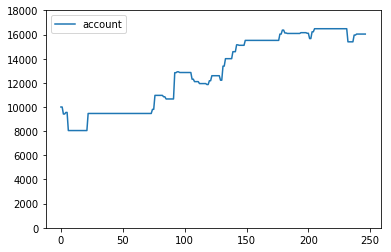

In [167]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, xgb_use=True, stop_loss=1500)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,18000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2688a8eb38>,
      dtype=object)

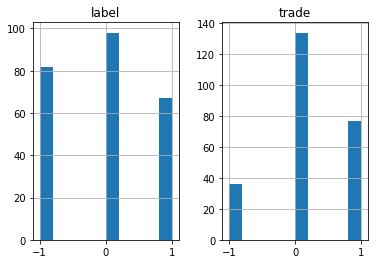

In [168]:
gold_account[['trade', 'label']].hist()

In [169]:
gold_account[gold_account['short'] == 1].gains.sum()

6038.000000000031

In [170]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

(0, 11000)

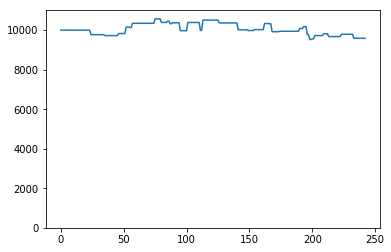

In [171]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, xgb_use=corn_xgb_use, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,11000)

In [172]:
corn_account[corn_account['short'] == 1].gains.sum()

-414.5

In [173]:
corn_account[corn_account['long'] == 1].gains.sum()

0.0

(0, 14000)

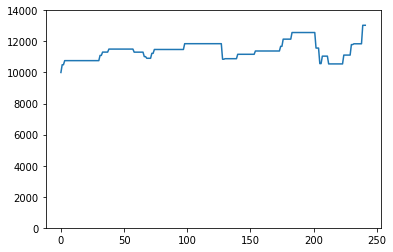

In [178]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, xgb_use=True, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,14000)

In [175]:
coffee_account[coffee_account['short'] == 1].gains.sum()

3039.562499999999

In [176]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0.0